# OpenXNAV Mission Planning Module

In this Python notebook, the ``mission_planning`` module from the OpenXNAV library is demonstrated.

We start by importing the necessary libraries:

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord,get_body
from astropy.time import Time,TimeDelta
from astropy.table import Table,QTable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Next we define the necessary variables that we will use to instantiate the orbit. We will define an elliptical orbit directly by its orbital elements in this example. Other options, which are currently commented out, are a circular orbit (special case of elliptical orbit where eccentricity = 0) and an elliptical orbit defined by its burnout trajectory.

In [2]:
# User definitions for elliptical orbital elements

e = 0.3           # eccentricity of the orbit
a = 750000*u.m    # semi-major axis 
inc = 20*u.deg    # inclination of orbit
w = 90*u.deg      # argument of periapsis
v_0 = 0*u.deg     # initial eccentric anomaly
Omega = 90*u.deg  # longitude of ascending node

import warnings
warnings.filterwarnings('ignore',message='leap-second file is expired')
t = Time.now() + TimeDelta(120*u.day) + TimeDelta(np.linspace(0,800,51)*u.s)

# Alternative: User definitions for elliptical orbital insertion 
# (note that this is just an example and would not generate the 
# same trajectory as the one above defined directly by orbital elements)

#e = 0.1          # eccentricity of the orbit, also user defined
#a = 750000*u.m   # m semi-major axis 
#B = 70*u.deg     # azimuth heading measured in degrees clockwise from north
#dec = 20*u.deg   # geocentric latitude in degrees (declination) of burnout
#v_0 = 0*u.deg    # initial eccentric anomaly

We can now do the same thing with a low-fidelity elliptical orbit, starting with the ``EllipticalOrbit`` class:

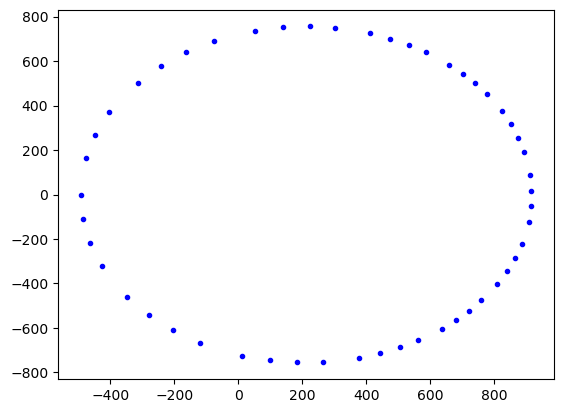

In [3]:
from mission_planning import EllipticalOrbit

eo = EllipticalOrbit(t,a,e,v_0=v_0,
                     inc=inc,w=w,
                     Omega=Omega)

plt.figure()
plt.plot(eo.x.to(u.km),eo.y.to(u.km),'b.')
#plt.xlim([-a/u.km,a/u.km])
#plt.ylim([-a/u.km,a/u.km])
plt.show()

While the above plot is represented in two dimensions as the projection of the orbit onto the XY-plane, this orbit was actually instantiated in 3D. To show the trajectory in the 3D Cartesian reference frame with the center of Earth at the origin, we just have to plot it in the 3D figure:

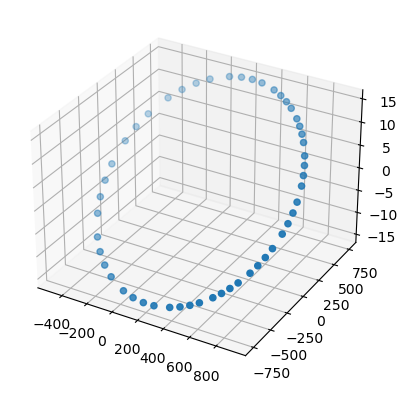

In [4]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(eo.x.to(u.km),eo.y.to(u.km),eo.z.to(u.km))

plt.show()

## Creating vectors from pulsar to space objects to look for access

In order to better demonstrate the pulsar access calculation functions in the OpenXNAV ``mission_planning`` module, we will create a SkyCoord object representing the moon, but with a distorted size and orbit to ensure some obfuscation of a chosen pulsar (whose coordinates are also exaggerated for demonstration purposes).

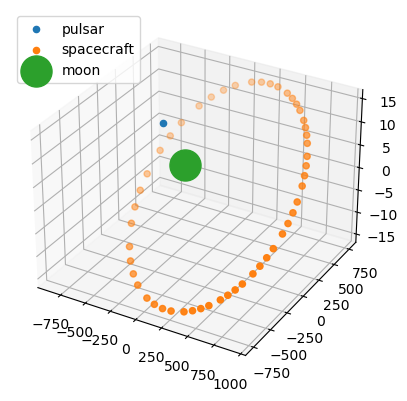

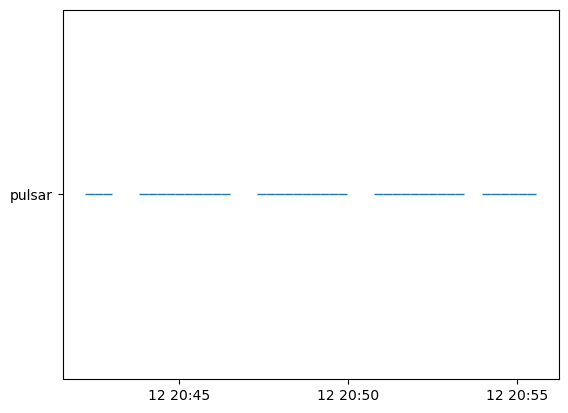

In [5]:
from mission_planning import plot_accesses

moon = SkyCoord(
    x = -284405*u.m,
    y = 249415*u.m,
    z = 0*u.m,
    frame='gcrs',
    representation_type = 'cartesian'
)

#moon_rad = 1740*u.km # actual radius of the moon 
moon_rad = 150*u.km # fake news 


# assuming we have the location of the pulsars, using one as an example
pulsar = SkyCoord(
    x = -853215*u.m,
    y = 748245*u.m,
    z = 0*u.km,
    frame='gcrs',
    representation_type = 'cartesian'
)

access = eo.pulsar_access(pulsar,moon,moon_rad)

# create figure to plot pulsar access
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(pulsar.x.to(u.km),pulsar.y.to(u.km),pulsar.z.to(u.km),label='pulsar')
ax.scatter(eo.x.to(u.km),eo.y.to(u.km),eo.z.to(u.km),label='spacecraft')
ax.scatter(moon.x.to(u.km),moon.y.to(u.km),moon.z.to(u.km),label='moon',s=500)
plt.legend()

plt.show()

fig = plt.figure()
ax = fig.add_subplot()
ax = plot_accesses(ax,t,{'pulsar':access})

We can also instantiate an ``EllipticalOrbit`` object with high fidelity. This version of the class calculates the eccentric anomaly at each time in the time array in order to calculate a more exact position.

There is currently a bug in this version that causes it to only output positive ``x`` and positive ``z`` values, so we'll need to fix that. (Negative values shown below are there because ``x`` and ``z`` are positive before coordinate rotation to account for longitude of ascending node, orbital inclination, and argument of periapsis)

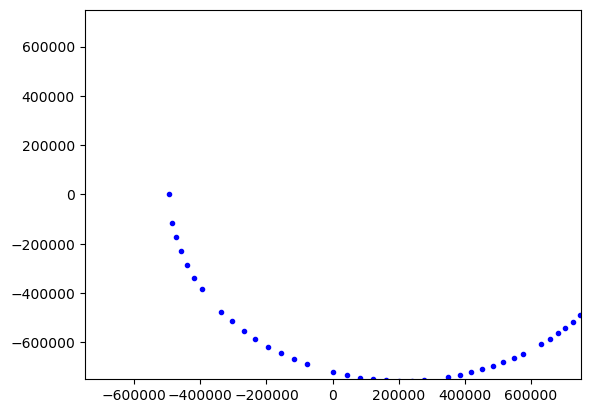

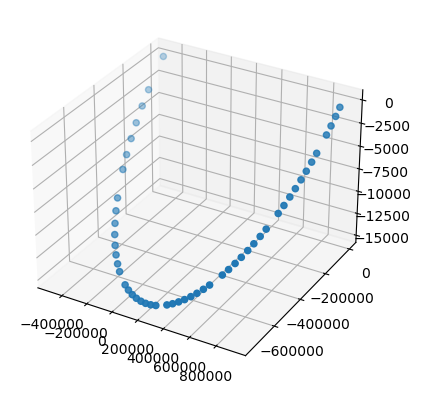

In [6]:
eo_h = EllipticalOrbit(t,a,e,v_0=v_0,
                        inc=inc,w=w,
                        Omega=Omega,
                        hifi=True)

plt.figure()
plt.plot(eo_h.x,eo_h.y,'b.')
plt.xlim([-a/u.m,a/u.m])
plt.ylim([-a/u.m,a/u.m])
plt.show()

fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(eo_h.x,eo_h.y,eo_h.z)

plt.show()

## Using the actual position of known celestial bodies
### Example 1 - Circular Orbit

Next we will take advantage of the `get_body` and `pulsar_access_export` functionalities of Astropy and OpenXNAV Mission Planning, respectively.

Astropy allows us to create a SkyCoord object using the actual location of the moon at any time or array of times. We will make our moon much bigger than in real life to ensure that we obfuscate some pulsars for demonstration purposes. We will define a new orbit circular orbit using the `CircularOrbit` class, which is a special case of the ``EllipticalOrbit`` class in which eccentricity and orbital inclination are zero.

In [7]:
from mission_planning import CircularOrbit

# User definitions for circular orbit
r = 360000*u.km
t0 = Time('2023-08-24 12:12:15.932083')
t = t0 + TimeDelta(np.linspace(0,25,100)*u.day)

moon = get_body('moon',t)
moon.representation_type='cartesian'
MOON_RAD = 1740*u.km

earth = get_body('earth',t)
earth.representation_type = 'cartesian'
EARTH_RAD = 6378.14*u.km

co = CircularOrbit(t,r)

Next we will create an ``astropy.table.Table`` object with some pulsars that we want to load in to our pulsar access export function. The table is shown and created here for demonstration purposes; however, tables with this format can be created in the OpenXNAV pulsar query module.

In [8]:
name = [    'J0002+6216' , 'J0006+1834' , 'J0007+7303' , 'J0011+08' , 'J0012+5431']
raJ_deg = [   0.74238    ,   1.52       ,  1.7571      ,  2.9       ,   3.0971     ] * u.deg
decJ_deg = [ 62.26928    ,  18.5831     ,  1.7571      ,  8.17      ,  54.5297     ] * u.deg
dist_kpc = [  6.357      ,   0.86       ,  1.4         ,  5.399     ,   5.425      ] * u.kpc

t = Table([name,raJ_deg,decJ_deg,dist_kpc],
          names = ['NAME','RAJD','DECJD','DIST'])

t.write('some_pulsars.fits',overwrite=True)
print(t)

   NAME      RAJD   DECJD    DIST
             deg     deg     kpc 
---------- ------- -------- -----
J0002+6216 0.74238 62.26928 6.357
J0006+1834    1.52  18.5831  0.86
J0007+7303  1.7571   1.7571   1.4
  J0011+08     2.9     8.17 5.399
J0012+5431  3.0971  54.5297 5.425


#### Using the ``pulsar_access_export`` method

Now that we have our spacecraft, moon, and pulsar table, we can use the `pulsar_access_export` method to create a table and plot of pulsar accesses. Both this method and the ``pulsar_access`` function allow you to account for obfuscation from multiple celestial bodies; just make sure to define them as shown below, entered before the keyword arguments and alternating between the ``SkyCoord`` object representing the celestial body and the radius of the body represented as an ``astropy.units.Quantity`` object.

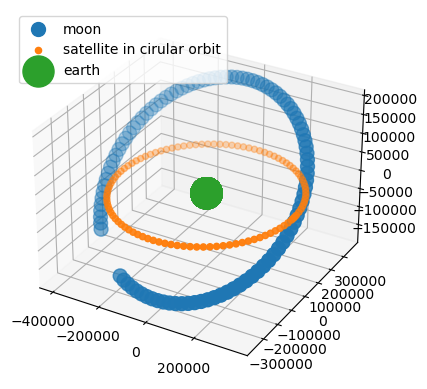

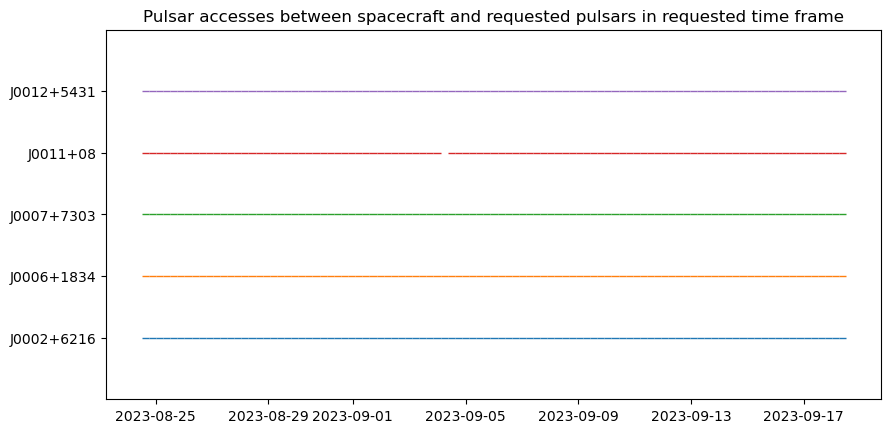

In [9]:
pulsars_qtbl = QTable.read('some_pulsars.fits')

# 3D plot of satellite orbit and moon
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(moon.x.to(u.km),moon.y.to(u.km),moon.z.to(u.km),label='moon',s=100)
ax1.scatter(co.x.to(u.km),co.y.to(u.km),co.z.to(u.km),label='satellite in cirular orbit')
ax1.scatter(earth.x.to(u.km),earth.y.to(u.km),earth.z.to(u.km),label='earth',s=500)
plt.legend(loc='upper left')

# Plot of pulsar accesses
_,(fig2,ax2) = co.pulsar_access_export(pulsars_qtbl,
                                       moon,MOON_RAD,
                                       earth,EARTH_RAD,
                                       make_csv=False,
                                       make_fig=True,save_fig=False)

### Example 2 - Elliptical Orbit

Next we will define a new elliptical orbit from the ``EllipticalOrbit`` class in which eccentricity and orbital inclination are non-zero. 

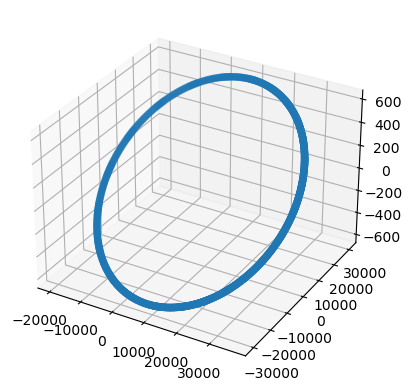

In [10]:
# User definitions for elliptical orbital elements

e = 0.3           # eccentricity of the orbit
a = 30000*u.km    # semi-major axis 
inc = 20*u.deg    # inclination of orbit
w = 90*u.deg      # argument of periapsis
v_0 = 0*u.deg     # initial eccentric anomaly
Omega = 90*u.deg  # longitude of ascending node

t0 = Time('2023-08-24 12:12:15.932')
t = t0 + TimeDelta(np.linspace(0,25,1000)*u.day)

moon = get_body('moon',t)
moon.representation_type='cartesian'
MOON_RAD = 1740*u.km

earth = SkyCoord(x=0*u.m,y=0*u.m,z=0*u.m,frame='gcrs',representation_type='cartesian')
EARTH_RAD = 6378.14*u.km

eo2 = EllipticalOrbit(t,a,e,v_0=v_0,
                     inc=inc,w=w,
                     Omega=Omega)

fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter(eo2.x.to(u.km),eo2.y.to(u.km),eo2.z.to(u.km))

plt.show()

Next we will create a CSV with some pulsars that we want to load in to our pulsar access export function. The CSV is shown and created here for demonstration purposes:

In [11]:
name = [    'J0002+6216' , 'J0006+1834' , 'J0007+7303' , 'J0011+08' , 'J0012+5431']
raJ_deg = [   0.74238    ,   1.52       ,  1.7571      ,  2.9       ,   3.0971     ] * u.deg
decJ_deg = [ 62.26928    ,  18.5831     ,  1.7571      ,  8.17      ,  54.5297     ] * u.deg
dist_kpc = [  6.357      ,   0.86       ,  1.4         ,  5.399     ,   5.425      ] * u.kpc

tbl = Table([name,raJ_deg,decJ_deg,dist_kpc],
          names = ['NAME','RAJD','DECJD','DIST'])

tbl.write('some_pulsars.fits',overwrite=True)
print(tbl)

   NAME      RAJD   DECJD    DIST
             deg     deg     kpc 
---------- ------- -------- -----
J0002+6216 0.74238 62.26928 6.357
J0006+1834    1.52  18.5831  0.86
J0007+7303  1.7571   1.7571   1.4
  J0011+08     2.9     8.17 5.399
J0012+5431  3.0971  54.5297 5.425


#### Using the ``pulsar_access_export`` method

Now that we have our spacecraft, moon, and pulsar CSV, we can use the ``pulsar_access_export`` method to create a table and plot of pulsar accesses. Both this method and the ``pulsar_access`` function allow you to account for obfuscation from multiple celestial bodies; just make sure to define them as shown below, entered before the keyword arguments and alternating between the SkyCoord object representing the celestial body and the radius of the body represented as an ``astropy.units.Quantity object``.

As part of the ``pulsar_access_export`` method call, we can write all pulsar access data to a CSV file. This CSV can then be used in the pulsar photon time-of-arrival simulation module to model the X-ray pulse sequence that the spacecraft would observe at those coordinates.

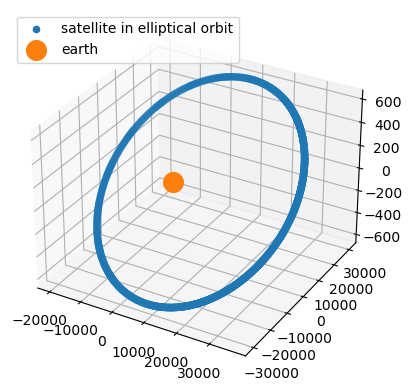

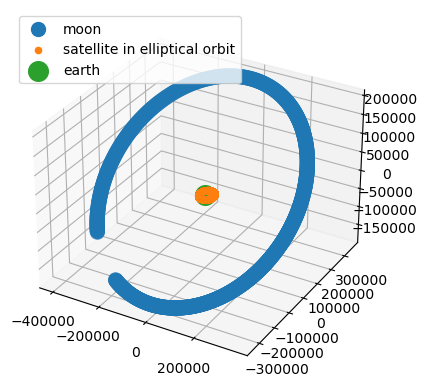

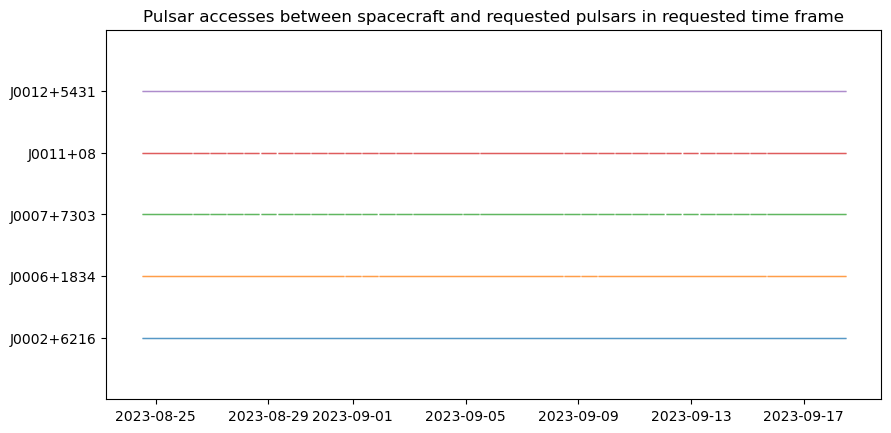

In [12]:
pulsars_qtbl = QTable.read('some_pulsars.fits')

# 3D plot of satellite orbit
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(eo2.x.to(u.km),eo2.y.to(u.km),eo2.z.to(u.km),label='satellite in elliptical orbit')
ax1.scatter(earth.x.to(u.km),earth.y.to(u.km),earth.z.to(u.km),label='earth',s=200)
plt.legend(loc='upper left')

# 3D plot of satellite orbit and moon
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(moon.x.to(u.km),moon.y.to(u.km),moon.z.to(u.km),label='moon',s=100)
ax2.scatter(eo2.x.to(u.km),eo2.y.to(u.km),eo2.z.to(u.km),label='satellite in elliptical orbit')
ax2.scatter(earth.x.to(u.km),earth.y.to(u.km),earth.z.to(u.km),label='earth',s=200)
plt.legend(loc='upper left')

# Plot of pulsar accesses, and save pulsar access table to CSV
accesses,(fig3,ax3) = eo2.pulsar_access_export(pulsars_qtbl,
                                               moon,MOON_RAD,
                                               earth,EARTH_RAD,
                                               make_csv=True,save_csv=True,
                                               make_fig=True,save_fig=False)

The breaks in the plot above might be hard to see since they are so small compared to the scale of the timeline displayed. We have therefore represented the breaks in tabular form below.

In [13]:
# Create DataFrame containing all times at which access to at least one pulsar is interrupted
access_breaks = accesses[accesses.all(axis=1) == False]
access_breaks

,Time_JDate,Spacecraft_pos_X_km,Spacecraft_pos_Y_km,Spacecraft_pos_Z_km,Spacecraft_vel_X_kmps,Spacecraft_vel_Y_kmps,Spacecraft_vel_Z_kmps,J0002+6216,J0006+1834,J0007+7303,J0011+08,J0012+5431
0,2.460181e+06,-19733.545037,2.343791e-12,4.132736e-13,4.667259,0.000000,0.000000,True,False,False,False,True
24,2.460182e+06,-19722.356542,-8.518943e+02,-1.662908e+01,4.663209,0.190622,0.065196,True,False,False,False,True
48,2.460182e+06,-19688.801001,-1.703092e+03,-3.324457e+01,4.651077,0.380744,0.130222,True,False,False,False,True
72,2.460183e+06,-19632.908273,-2.552897e+03,-4.983288e+01,4.630912,0.569870,0.194907,True,True,False,False,True
96,2.460183e+06,-19554.728216,-3.400614e+03,-6.638041e+01,4.602798,0.757509,0.259083,True,True,False,False,True
120,2.460184e+06,-19454.330828,-4.245547e+03,-8.287361e+01,4.566851,0.943180,0.322587,True,True,False,False,True
143,2.460185e+06,-19264.410077,5.493859e+03,1.072408e+02,4.499325,-1.214310,-0.415318,True,True,False,True,True
144,2.460185e+06,-19331.806438,-5.087002e+03,-9.929892e+01,4.523216,1.126412,0.385256,True,True,False,False,True
167,2.460185e+06,-19397.632920,4.654341e+03,9.085332e+01,4.546627,-1.032427,-0.353111,True,True,False,False,True
168,2.460185e+06,-19187.265950,-5.924286e+03,-1.156428e+02,4.472073,1.306749,0.446935,True,True,False,False,True


# Substituting STK for OpenXNAV Mission Planning

As an alternative to the ``mission_planning`` module built into OpenXNAV, users can also plan their missions and generate trajectory and pulsar access inputs using the mission planning software of their choice, such as ANSYS STK. STK is very visual, and a great option if you’re starting your mission plan from scratch and want a lot of flexibility in designing your spacecraft trajectory.

STK users who choose this route should follow the following steps:

1. Create a new scenario in STK, including the time over which you are interested in analyzing.
2. Export the .st files from the OpenXNAV Pulsar Query module and then open them within your new scenario as star objects:

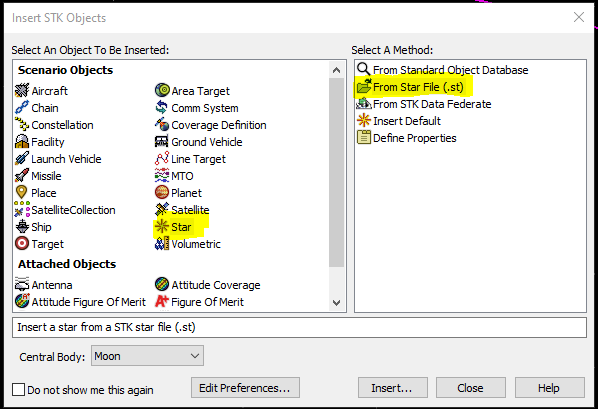

3. Add in a new satellite object and customize the trajectory to your desired level of complexity:

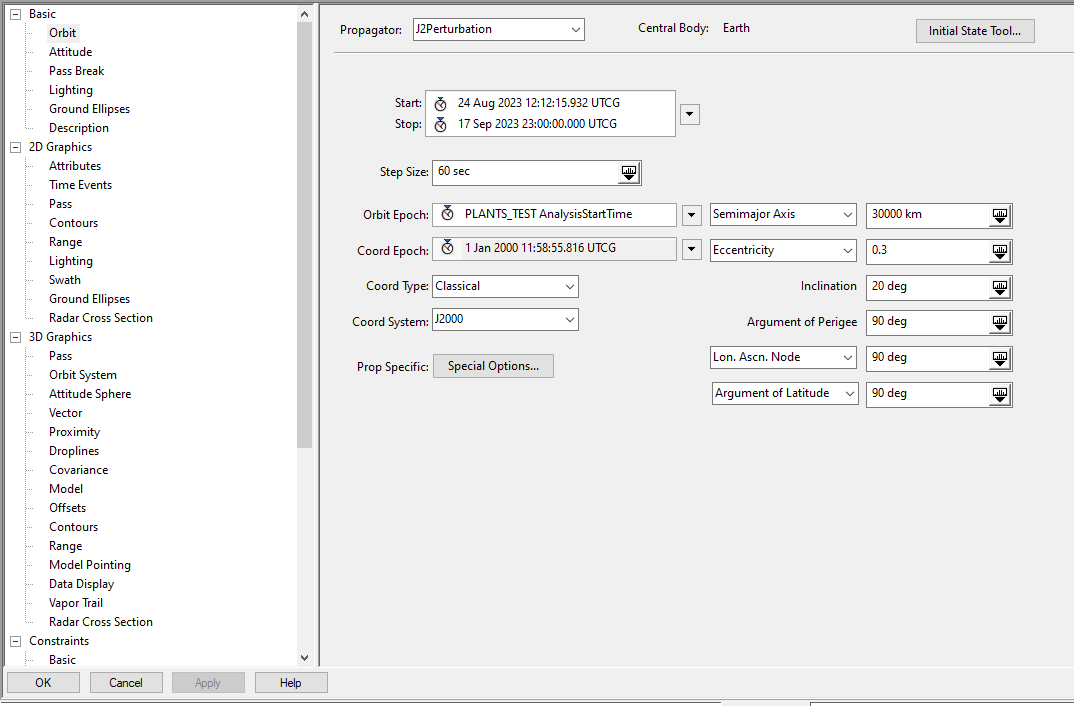

4. Create planets for any celestial bodies you would like to be included as obstacles in viewing pulsars (ex: Moon):

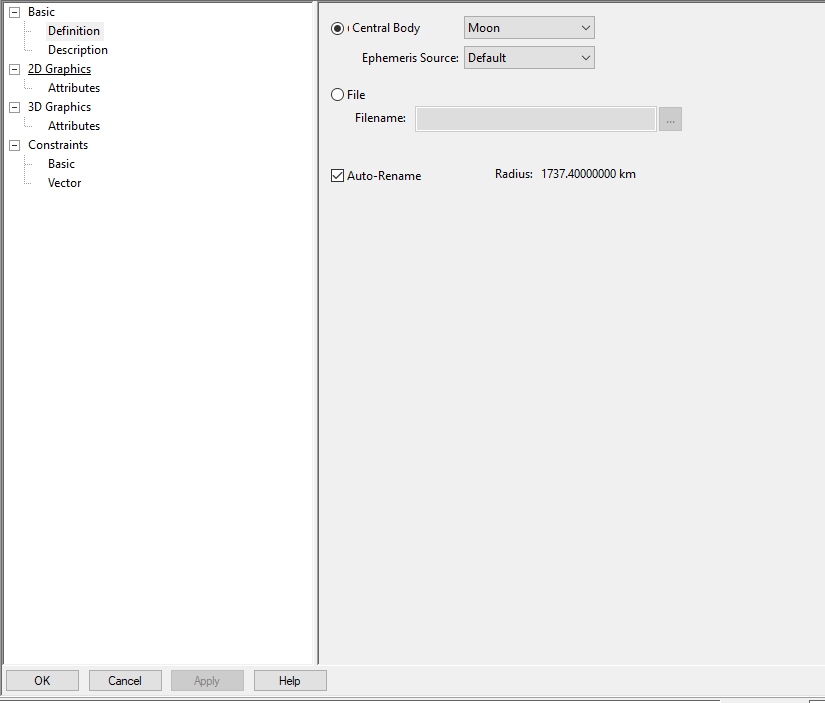

5. Within your satellite object, create a special constraint (i.e. object exclusions) and select your obstacle planets:

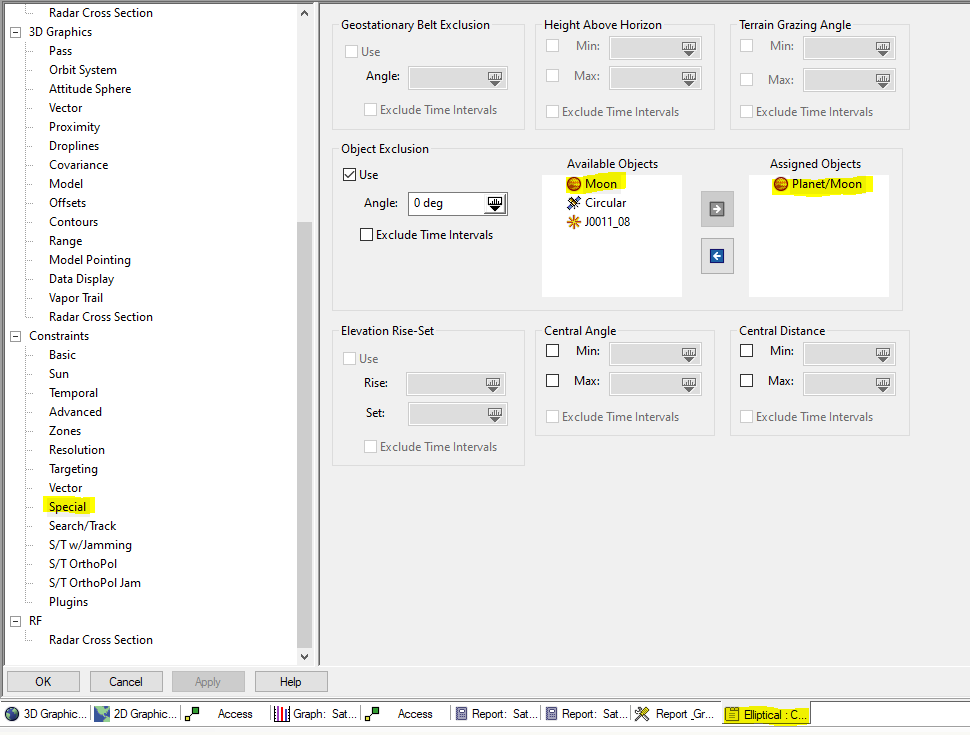

6. Go to Analysis, create accesses between the satellite and the imported pulsar over your scenario window:

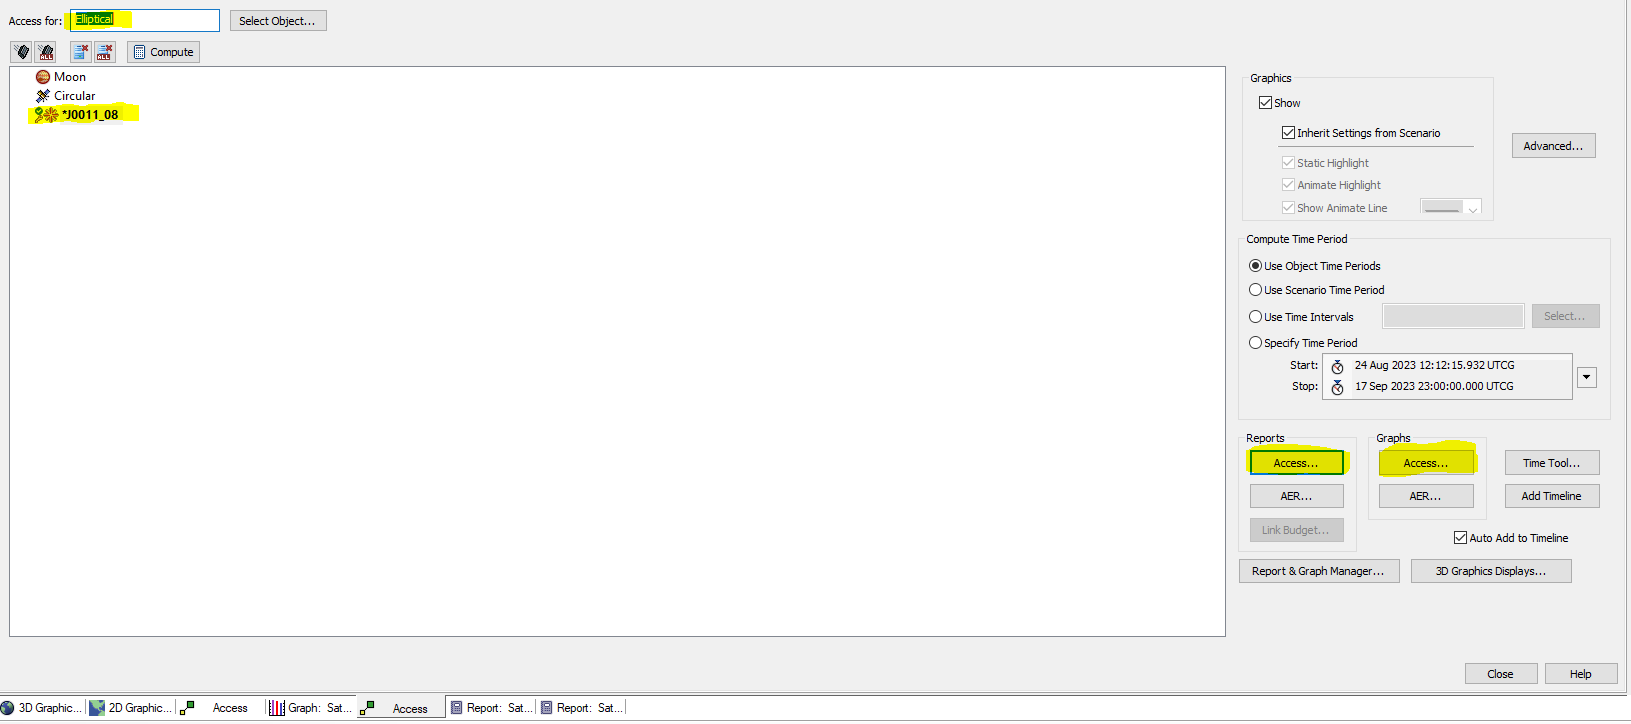

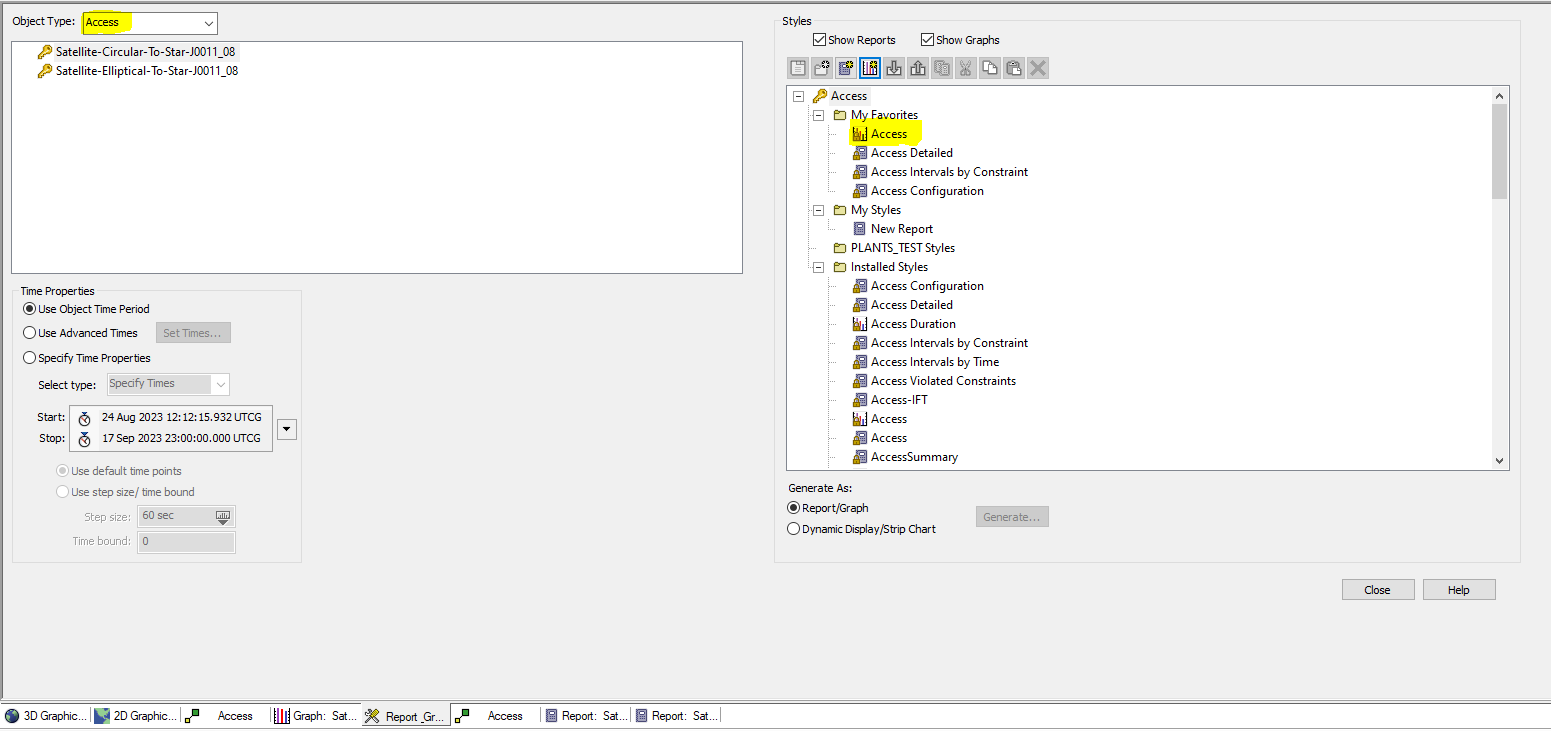

7. Export the access windows as an image and the satellite trajectory in ECEF text file with position and velocity:

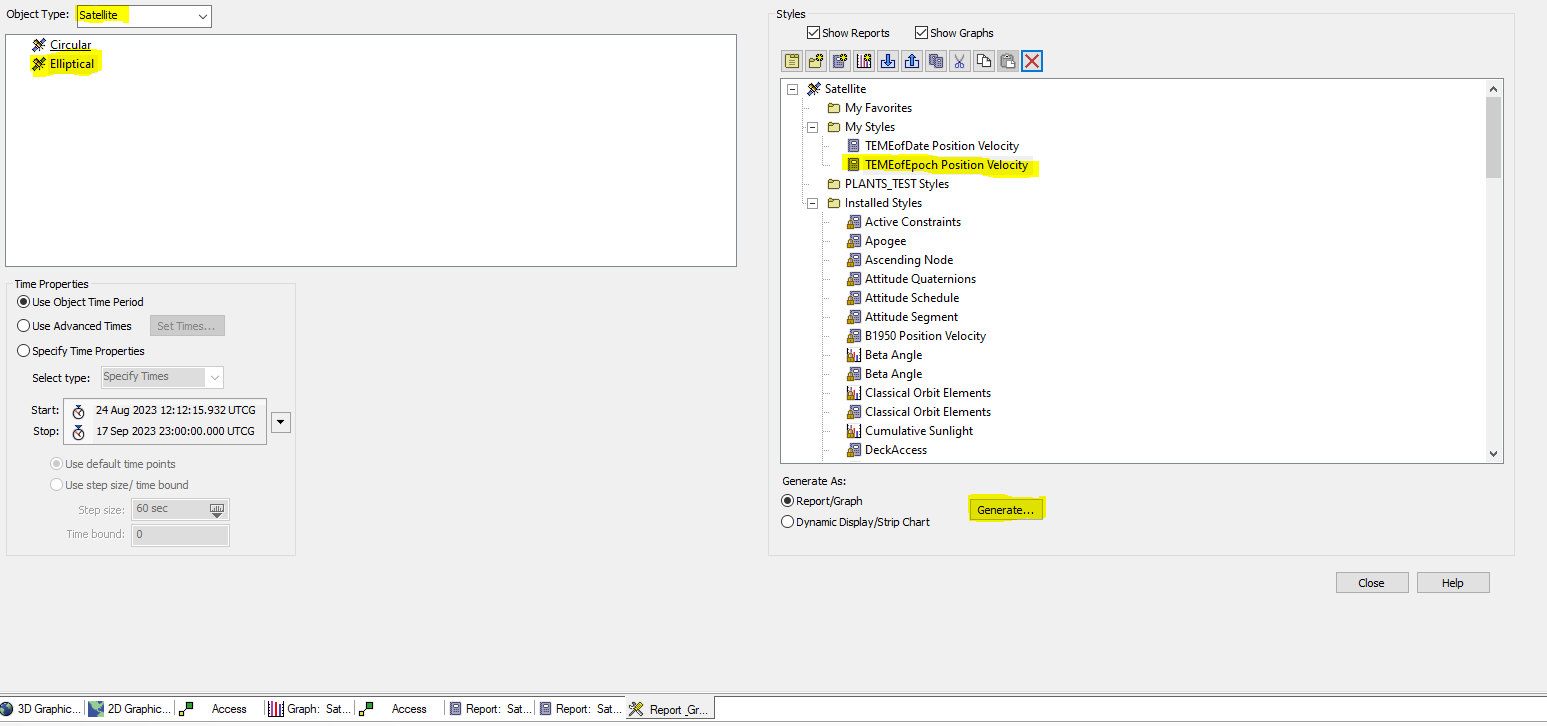